<a href="https://colab.research.google.com/github/rachdancer/FI-Code/blob/main/Yield_Curve_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import numpy as np
import statsmodels.api as sm


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pip install nelson_siegel_svensson

Best fit param: (RSqr=0.904)
tau=10.00 intercept=0.630 beta1=-1.137 beta2=1.987


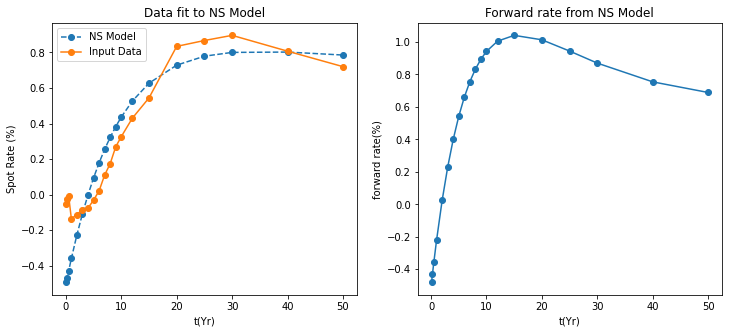

Best fit param: (RSqr=0.994)
tau1=10.00 tau2=5.00 intercept=0.027 beta1=-0.010 beta2=5.764 beta3=-4.141


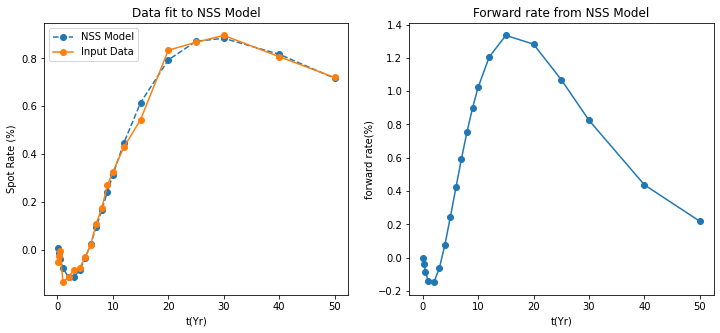

In [4]:
class NSCurveFamily:
    '''
    The class fit data into Nelson Siegel and Nelson Siegel Svensson Models.
    Parsimonious Modeling of Yield Curves
    '''
        
    def __init__(self, useNSS=False):
        ''' initialised with True if use Nelson Siegel Svensson Model
        initialised with False if use Nelson Siegel Model
        '''
        self.useNSS = useNSS
        self.HasEstParam = False

    def fitNSModel(self, tau, t_seq, zr_seq):
        t_to_tau = [ t/tau  for t in t_seq]
        xterm1 = [ (1.0-math.exp(-tt))/tt for tt in t_to_tau]
        xterm2 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau]
        x = np.array([xterm1, xterm2]).T
        x = sm.add_constant(x)
        wt=np.append(t_seq[0],np.diff(t_seq))
        #Use the weighted OLS with the weight proportional to the tenor between data points
        #This intends to give equal wt to the full yield curve rather than overweight the portion with a lot of samples        
        res = sm.WLS(zr_seq, x, wt).fit()
        return (res.params, res.rsquared)    
    
    def fitNSSModel(self, tau1, tau2, t_seq, zr_seq):
        t_to_tau1 = [ t/tau1  for t in t_seq]
        t_to_tau2 = [ t/tau2  for t in t_seq]

        xterm1 = [ (1.0-math.exp(-tt))/tt for tt in t_to_tau1]
        xterm2 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau1]
        xterm3 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau2]

        x = np.array([xterm1, xterm2, xterm3]).T
        x = sm.add_constant(x)
        wt=np.append(t_seq[0],np.diff(t_seq))
        #Use the weighted OLS with the weight proportional to the tenor between data points
        #This intends to give equal wt to the full yield curve rather than overweight the portion with a lot of samples        
        res = sm.WLS(zr_seq, x, wt).fit()
        return (res.params, res.rsquared)
         
    def estNSParam(self, t_seq, zr_seq):
        #for yield curve estimation the search space in time is not likely to be outside front part of the curve
        tau_univ = [0.1, 0.15, 0.2, 0.3, 0.5, 0.75, 1, 1.5, 2, 3, 5, 7.5, 10]                
        rsq_univ = [ self.fitNSModel(tau, t_seq, zr_seq)[1] for tau in tau_univ]
        opt_tau = tau_univ[np.argmax(rsq_univ)]
        opt_param, opt_rsqr = self.fitNSModel(opt_tau, t_seq, zr_seq)
        return (opt_param, opt_tau, opt_rsqr)
    
    def estNSSParam(self, t_seq, zr_seq):
        #for yield curve estimation the search space in time is not likely to be outside  front part of the curve
        tau_univ = [0.1, 0.15, 0.2, 0.3, 0.5, 0.75, 1, 1.5, 2, 3, 5, 7.5, 10]
        nTau = len(tau_univ)
        rsq_univ = np.array([ self.fitNSSModel(tau0, tau1, t_seq, zr_seq)[1] for tau0 in tau_univ for tau1 in tau_univ])
        rsq_univ = rsq_univ.reshape((nTau,nTau))    
        maxidx = np.argmax(rsq_univ)
        opt_tau0, opt_tau1 = tau_univ[maxidx // nTau], tau_univ[maxidx % nTau]
        opt_param, opt_rsqr = self.fitNSSModel(opt_tau0, opt_tau1, t_seq, zr_seq)
        return (opt_param, opt_tau0, opt_tau1, opt_rsqr)    

    def estimateParam(self, t_seq, zr_seq):
        ''' Estimate model parameters by grid search
        t_seq: pandas series, time in year
        zr_seq: pandas series, spot rate 
        '''        
        if self.useNSS:
            param, tau0, tau1, rsqr = self.estNSSParam(t_seq, zr_seq)
            self.beta0, self.beta1, self.beta2, self.beta3=param
            self.tau0, self.tau1, self.rsqr = tau0, tau1, rsqr
        else:
            param, tau, rsqr = self.estNSParam(t_seq, zr_seq)
            self.beta0, self.beta1, self.beta2=param
            self.tau0, self.rsqr = tau, rsqr
            self.tau1, self.beta3 = float('nan'), float('nan')
        self.HasEstParam=True
        
    def getSpot(self, t_seq):
        ''' Return the spot rate based upon the estimated parameters
        t_seq: pandas series, time in year
        ''' 
        if self.HasEstParam == False:
            raise Exception('Parameters are not available')
        if self.useNSS:
            t_to_tau1 = [ t/self.tau0  for t in t_seq]
            t_to_tau2 = [ t/self.tau1  for t in t_seq]
            xterm1 = [ (1.0-math.exp(-tt))/tt for tt in t_to_tau1]
            xterm2 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau1]
            xterm3 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau2]
            param = [self.beta0, self.beta1, self.beta2, self.beta3]
            x = np.array([xterm1, xterm2, xterm3]).T
            x = sm.add_constant(x)
        else:
            t_to_tau = [ t/self.tau0  for t in t_seq]
            xterm1 = [ (1.0-math.exp(-tt))/tt for tt in t_to_tau]
            xterm2 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau]
            param = [self.beta0, self.beta1, self.beta2]
            x = np.array([xterm1, xterm2]).T
            x = sm.add_constant(x)
        return x.dot(param)
        

    def getFwdRate(self, t_seq):
        ''' Return the forward rate based upon the estimated parameters
        t_seq: pandas series, time in year
        ''' 
        if self.HasEstParam == False:
            raise Exception('Parameters are not available')
        if self.useNSS:
            t_to_tau1 = [ t/self.tau0  for t in t_seq]
            t_to_tau2 = [ t/self.tau1  for t in t_seq]
            xterm1 = [ math.exp(-tt) for tt in t_to_tau1]
            xterm2 = [ tt*math.exp(-tt) for tt in t_to_tau1]
            xterm3 = [ tt*math.exp(-tt) for tt in t_to_tau2]
            param = [self.beta0, self.beta1, self.beta2, self.beta3]
            x = np.array([xterm1, xterm2, xterm3]).T
            x = sm.add_constant(x)
        else:
            t_to_tau = [ t/self.tau0  for t in t_seq]
            xterm1 = [ math.exp(-tt) for tt in t_to_tau]
            xterm2 = [ tt*math.exp(-tt) for tt in t_to_tau]
            param = [self.beta0, self.beta1, self.beta2]
            x = np.array([xterm1, xterm2]).T
            x = sm.add_constant(x)
        return x.dot(param)        


import pandas as pd
import matplotlib.pyplot as plt

def main():
    #Data source for UK Gilt Spot Rates: BB
    #Date: 29/01/2021
    colHdr = ['Tenor','Yield Curve (UKT)']
    zrdata = [[0.083333,-0.052],[0.25,-0.024],[0.5,-0.005],[1,-0.136],[2,-0.112],[3,-0.084],[4,-0.076],[5,-0.031],[6,0.021],[7,0.11],[8,0.174],
              [9,0.269],[10,0.326],[12,0.43],[15,0.544],[20,0.834],[25,0.867],[30,0.896],[40,0.807],[50,0.72]]

    data=pd.DataFrame(zrdata, columns=colHdr)
    tIdxName, rateColName = 'Tenor', 'Yield Curve (UKT)'
    tenor, y = data[tIdxName], data[rateColName]

    nsm = NSCurveFamily(False)
    nsm.estimateParam(tenor, y)

    print('Best fit param: (RSqr=%.3f)' % nsm.rsqr)
    print('tau=%.2f intercept=%.3f beta1=%.3f beta2=%.3f' % (nsm.tau0, nsm.beta0, nsm.beta1, nsm.beta2) )

    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(tenor, nsm.getSpot(tenor), 'o--', label='NS Model')
    plt.plot(tenor, y, 'o-', label='Input Data')
    plt.title('Data fit to NS Model')
    plt.xlabel('t(Yr)')
    plt.ylabel('Spot Rate (%)')
    plt.legend()
    plt.subplot(122)
    plt.plot(tenor, nsm.getFwdRate(tenor), 'o-', label='NS Model')
    plt.title('Forward rate from NS Model')
    plt.xlabel('t(Yr)')
    plt.ylabel('forward rate(%)')
    plt.show()

    nssm = NSCurveFamily(True)
    nssm.estimateParam(tenor, y)

    print('Best fit param: (RSqr=%.3f)' % nssm.rsqr)
    print('tau1=%.2f tau2=%.2f intercept=%.3f beta1=%.3f beta2=%.3f beta3=%.3f' % (nssm.tau0, nssm.tau1, nssm.beta0, nssm.beta1, nssm.beta2, nssm.beta3) )

    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(tenor, nssm.getSpot(tenor), 'o--', label='NSS Model')
    plt.plot(tenor, y, 'o-', label='Input Data')
    plt.title('Data fit to NSS Model')
    plt.xlabel('t(Yr)')
    plt.ylabel('Spot Rate (%)')
    plt.legend()
    plt.subplot(122)
    plt.plot(tenor, nssm.getFwdRate(tenor), 'o-', label='NSS Model')
    plt.title('Forward rate from NSS Model')
    plt.xlabel('t(Yr)')
    plt.ylabel('forward rate(%)')
    plt.show()


if __name__ == "__main__":
    main()